Data Science 2252-INSY-5378-001-DATA SCIENCE:PROG APPROACH Final Project

Puja Kumari

Rajvi Kapadia

Manoj Pasunoori

In [1]:
!pip install scikit-learn
!pip install imblearn
!pip install shap xgboost


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#  Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")


Preprocessing

In [3]:
# Load Data
original_df = pd.read_csv(r"C:\Users\mxp8594\Downloads\US_Accidents_March23.csv")
print("Initial Snapshot:\n", original_df.head())


Initial Snapshot:
     ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False        

In [4]:
import pandas as pd

# Sample size
sample_size = 1_000_000

# Calculate class proportions
class_probs = original_df['Severity'].value_counts(normalize=True)
class_sample_sizes = (class_probs * sample_size).round().astype(int)

# Take stratified sample
df = (
    original_df.groupby('Severity', group_keys=False)
    .apply(lambda x: x.sample(n=class_sample_sizes.loc[x.name], random_state=42))
    .reset_index(drop=True)
)

# Optional: Check the new class distribution
print(df['Severity'].value_counts(normalize=True))
print("Sampled Data Shape:", df.shape)


Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64
Sampled Data Shape: (1000000, 46)


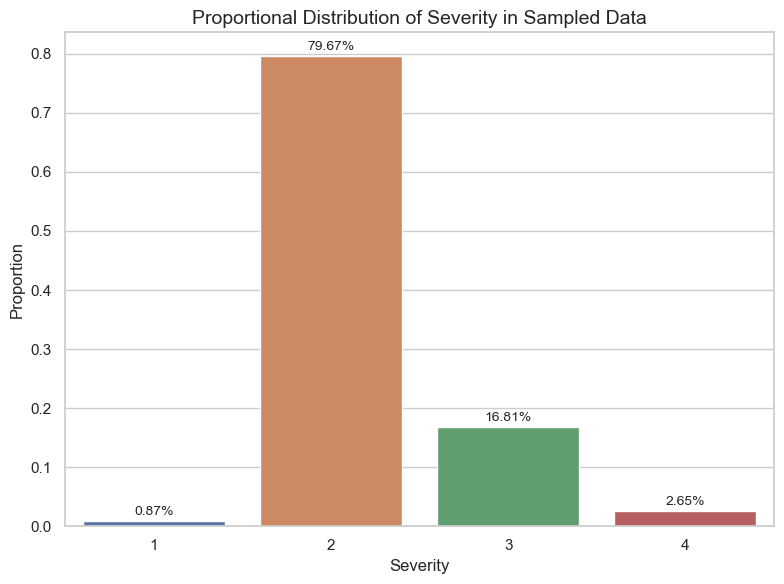

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Calculate class distribution
severity_counts = df['Severity'].value_counts(normalize=True).sort_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=severity_counts.index, y=severity_counts.values)

# Add value labels
for i, val in enumerate(severity_counts.values):
    plt.text(i, val + 0.005, f'{val:.2%}', ha='center', va='bottom', fontsize=10)

plt.title("Proportional Distribution of Severity in Sampled Data", fontsize=14)
plt.xlabel("Severity", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# Drop Irrelevant Columns
columns_to_drop = ['ID', 'City', 'Amenity', 'Railway', 'Timezone', 'No_Exit',
                   'Traffic_Calming', 'Turning_Loop', 'Roundabout', 'Bump', 'Source', 'Street',
                   'State', 'Zipcode', 'County', 'Country', 'Airport_Code', 'Description', 'Weather_Timestamp']

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert Start_Time and End_Time to datetime with format
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')


# Extract the hour from Start_Time and End_Time and categorize them
df['Start_Time'] = df['Start_Time'].dt.hour + 1  # 0-1 is Category 1, 1-2 is Category 2, etc.
df['End_Time'] = df['End_Time'].dt.hour + 1

df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),...,Crossing,Give_Way,Junction,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,1,16.0,16.0,38.087530,-85.667570,38.08753,-85.66757,0.0,68.0,68.0,...,False,False,False,False,False,True,Day,Day,Day,Day
1,1,17.0,18.0,34.860432,-82.270523,NaN,NaN,0.0,94.0,94.0,...,False,False,False,False,False,True,Day,Day,Day,Day
2,1,12.0,13.0,35.142311,-85.247063,NaN,NaN,0.0,81.0,81.0,...,False,False,False,False,False,False,Day,Day,Day,Day
3,1,18.0,19.0,33.494830,-112.030210,33.49483,-112.03021,0.0,76.0,76.0,...,True,False,False,False,False,True,Day,Day,Day,Day
4,1,21.0,22.0,38.660870,-121.346870,NaN,NaN,0.0,72.0,72.0,...,False,False,False,False,False,True,Night,Day,Day,Day


In [7]:
# Simple summary of missing values
print(df.isnull().sum())


Severity                      0
Start_Time                95600
End_Time                  95600
Start_Lat                     0
Start_Lng                     0
End_Lat                  439915
End_Lng                  439915
Distance(mi)                  0
Temperature(F)            21075
Wind_Chill(F)            258342
Humidity(%)               22410
Pressure(in)              18090
Visibility(mi)            22900
Wind_Direction            22514
Wind_Speed(mph)           73853
Precipitation(in)        285078
Weather_Condition         22447
Crossing                      0
Give_Way                      0
Junction                      0
Station                       0
Stop                          0
Traffic_Signal                0
Sunrise_Sunset             3012
Civil_Twilight             3012
Nautical_Twilight          3012
Astronomical_Twilight      3012
dtype: int64


In [8]:
df.dtypes

Severity                   int64
Start_Time               float64
End_Time                 float64
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Crossing                    bool
Give_Way                    bool
Junction                    bool
Station                     bool
Stop                        bool
Traffic_Signal              bool
Sunrise_Sunset            object
Civil_Twilight            object
Nautical_Twilight         object
Astronomical_Twilight     object
dtype: object

In [9]:
# Handle Missing Values

numerical_cols = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng','Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                  'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)','Start_Time', 'End_Time','Distance(mi)' ]
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = ['Civil_Twilight', 'Weather_Condition', 'Sunrise_Sunset',
                    'Nautical_Twilight', 'Astronomical_Twilight']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')


In [10]:
#Encode Categorical Features
categorical_columns = ['Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',
                       'Nautical_Twilight', 'Astronomical_Twilight', 'Crossing',
                       'Give_Way', 'Junction', 'Station', 'Stop', 'Traffic_Signal',
                       'Civil_Twilight']

one_hot_columns = ['Weather_Condition', 'Wind_Direction']

#Label encoding
label_encoded_columns = [col for col in categorical_columns if col not in one_hot_columns]

label_encoder = LabelEncoder()
for col in label_encoded_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

#get dummies
df = pd.get_dummies(df, columns=one_hot_columns, drop_first=True)


print("Df shape after encoding:")
print(df.shape)


Df shape after encoding:
(1000000, 167)


In [11]:
#Combine Severity Categories

# Original Severity:
# 1 and 2 → Mild/Moderate → 0
# 3 and 4 → Severe → 1

severity_map = {1: 0, 2: 0, 3: 1, 4: 1}
df = df[df['Severity'].isin(severity_map.keys())]  # Filter valid severities
df['Severity'] = df['Severity'].map(severity_map)

print("\n Severity distribution after combining:")
print(df['Severity'].value_counts(normalize=True).round(4))



 Severity distribution after combining:
Severity
0    0.8054
1    0.1946
Name: proportion, dtype: float64


In [12]:
from sklearn.decomposition import PCA
import pandas as pd

# Identify Weather One-Hot Columns
weather_cols = [col for col in df.columns if 'Weather_Condition_' in col]
print(f"Found {len(weather_cols)} one-hot encoded Weather_Condition columns.")

#  Apply PCA directly to one-hot encoded columns
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
weather_pca = pca.fit_transform(df[weather_cols])

#  Get number of components
n_components_selected = pca.n_components_
print("")
print(f"PCA has compressed {len(weather_cols)} columns → {n_components_selected} components (95% variance retained)")

#  Create new PCA feature columns
weather_pca_df = pd.DataFrame(weather_pca, columns=[f'Weather_PCA_{i+1}' for i in range(n_components_selected)])

#  Replace original weather columns with PCA features
df.drop(columns=weather_cols, inplace=True)
df = pd.concat([df.reset_index(drop=True), weather_pca_df.reset_index(drop=True)], axis=1)

# Step 6: Display final DataFrame shape
print(f"Final shape after replacing Weather_Condition with PCA: {df.shape}")


Found 119 one-hot encoded Weather_Condition columns.

PCA has compressed 119 columns → 13 components (95% variance retained)
Final shape after replacing Weather_Condition with PCA: (1000000, 61)


In [13]:
df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),...,Weather_PCA_4,Weather_PCA_5,Weather_PCA_6,Weather_PCA_7,Weather_PCA_8,Weather_PCA_9,Weather_PCA_10,Weather_PCA_11,Weather_PCA_12,Weather_PCA_13
0,0,16.0,16.0,38.087530,-85.667570,38.087530,-85.667570,0.0,68.0,68.0,...,-0.095673,-0.113280,-0.015785,-0.037910,-0.012048,-0.012850,-0.008319,-0.004687,-0.002841,-0.005206
1,0,17.0,18.0,34.860432,-82.270523,36.181964,-88.040183,0.0,94.0,94.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.001070,-0.002008
2,0,12.0,13.0,35.142311,-85.247063,36.181964,-88.040183,0.0,81.0,81.0,...,-0.095673,-0.113280,-0.015785,-0.037910,-0.012048,-0.012850,-0.008319,-0.004687,-0.002841,-0.005206
3,0,18.0,19.0,33.494830,-112.030210,33.494830,-112.030210,0.0,76.0,76.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.001070,-0.002008
4,0,21.0,22.0,38.660870,-121.346870,36.181964,-88.040183,0.0,72.0,72.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.001070,-0.002008


In [14]:
df['Severity'].value_counts()

Severity
0    805387
1    194613
Name: count, dtype: int64


 Shape Before Outlier Removal: (1000000, 61)
 Found 27 numerical features for outlier detection.


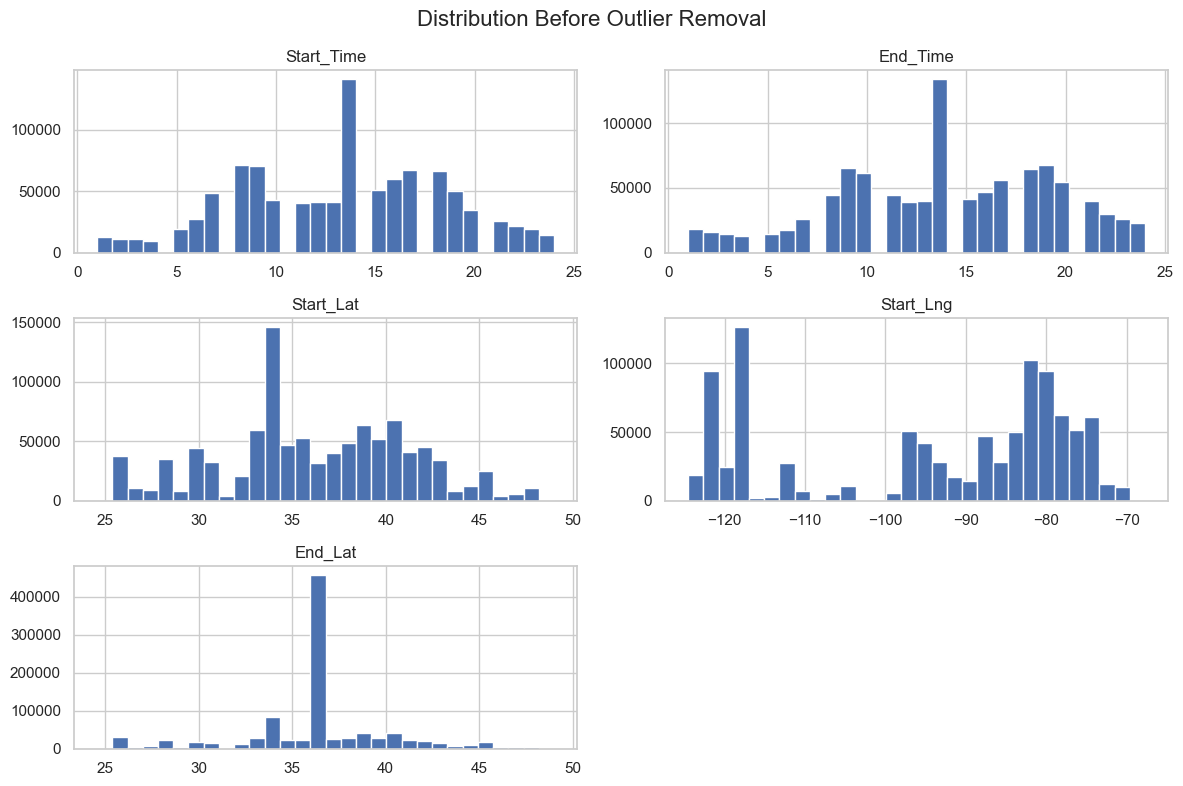

 Start_Time: Q1=9.00, Q3=17.00, IQR=8.00, Bounds=(-3.00, 29.00)
 End_Time: Q1=10.00, Q3=18.00, IQR=8.00, Bounds=(-2.00, 30.00)
 Start_Lat: Q1=33.40, Q3=40.08, IQR=6.68, Bounds=(23.37, 50.11)
 Start_Lng: Q1=-117.23, Q3=-80.36, IQR=36.87, Bounds=(-172.54, -25.05)
 End_Lat: Q1=35.18, Q3=37.52, IQR=2.34, Bounds=(31.67, 41.03)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Shape before removal
print("\n Shape Before Outlier Removal:", df.shape)

#  Identify numerical features (excluding target)
numerical_features = [col for col in df.columns if col != 'Severity' and df[col].dtype in ['int64', 'float64']]
print(f" Found {len(numerical_features)} numerical features for outlier detection.")

#  Visualize original data distribution for a few columns
sample_cols = numerical_features[:5]  # Pick first 5 numerical columns
df[sample_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Distribution Before Outlier Removal", fontsize=16)
plt.tight_layout()
plt.show()

# Create mask to retain rows within acceptable range for ALL numerical columns
mask = np.ones(len(df), dtype=bool)

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Print IQR info for first few columns
    if col in sample_cols:
        print(f" {col}: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}, Bounds=({lower_bound:.2f}, {upper_bound:.2f})")

    mask &= df[col].between(lower_bound, upper_bound)

# Apply mask to remove outliers
df = df[mask]




 Shape After Outlier Removal: (124836, 61)

 Target Distribution After Outlier Removal:
Severity
0    99980
1    24856
Name: count, dtype: int64


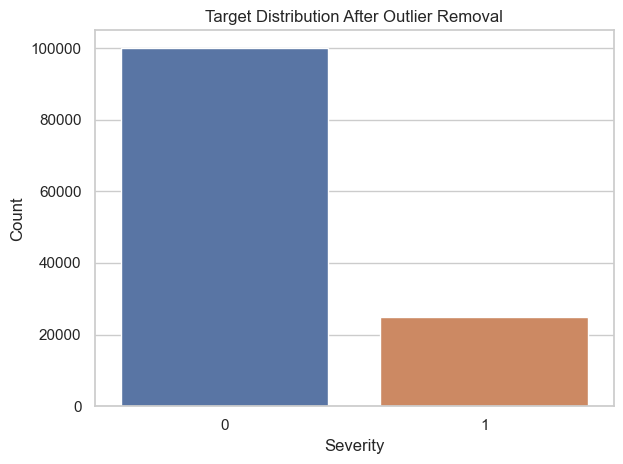

In [16]:
# Post-removal shape and distribution
print("\n Shape After Outlier Removal:", df.shape)
print("\n Target Distribution After Outlier Removal:")
print(df['Severity'].value_counts())

# Visualize severity after outlier removal
sns.countplot(data=df, x='Severity')
plt.title("Target Distribution After Outlier Removal")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [17]:
df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),...,Weather_PCA_4,Weather_PCA_5,Weather_PCA_6,Weather_PCA_7,Weather_PCA_8,Weather_PCA_9,Weather_PCA_10,Weather_PCA_11,Weather_PCA_12,Weather_PCA_13
1,0,17.0,18.0,34.860432,-82.270523,36.181964,-88.040183,0.0,94.0,94.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
4,0,21.0,22.0,38.660870,-121.346870,36.181964,-88.040183,0.0,72.0,72.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
7,0,18.0,18.0,35.483261,-97.525497,36.181964,-88.040183,0.0,91.0,91.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
15,0,9.0,10.0,34.800980,-82.206261,36.181964,-88.040183,0.0,73.0,73.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
18,0,7.0,9.0,40.022449,-76.192902,36.181964,-88.040183,0.0,67.0,67.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008


In [18]:
df['Severity'].value_counts()

Severity
0    99980
1    24856
Name: count, dtype: int64

In [19]:
df[numerical_features]

,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),...,Weather_PCA_4,Weather_PCA_5,Weather_PCA_6,Weather_PCA_7,Weather_PCA_8,Weather_PCA_9,Weather_PCA_10,Weather_PCA_11,Weather_PCA_12,Weather_PCA_13
1,17.0,18.0,34.860432,-82.270523,36.181964,-88.040183,0.000,94.0,94.0,37.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
4,21.0,22.0,38.660870,-121.346870,36.181964,-88.040183,0.000,72.0,72.0,31.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
7,18.0,18.0,35.483261,-97.525497,36.181964,-88.040183,0.000,91.0,91.0,26.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
15,9.0,10.0,34.800980,-82.206261,36.181964,-88.040183,0.000,73.0,73.0,78.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
18,7.0,9.0,40.022449,-76.192902,36.181964,-88.040183,0.000,67.0,67.0,87.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999913,21.0,23.0,33.054259,-84.098776,33.052554,-84.109768,0.647,50.0,50.0,47.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
999954,24.0,3.0,40.738702,-75.270814,40.738177,-75.273892,0.165,75.0,75.0,73.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
999979,24.0,9.0,40.651101,-75.463635,40.650007,-75.466364,0.162,33.0,33.0,82.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008
999983,14.0,14.0,34.973431,-79.007996,34.973635,-79.007231,0.046,68.0,68.0,33.0,...,-0.014768,-0.029549,-0.004652,-0.012639,-0.004202,-0.004637,-0.003069,-0.001752,-0.00107,-0.002008


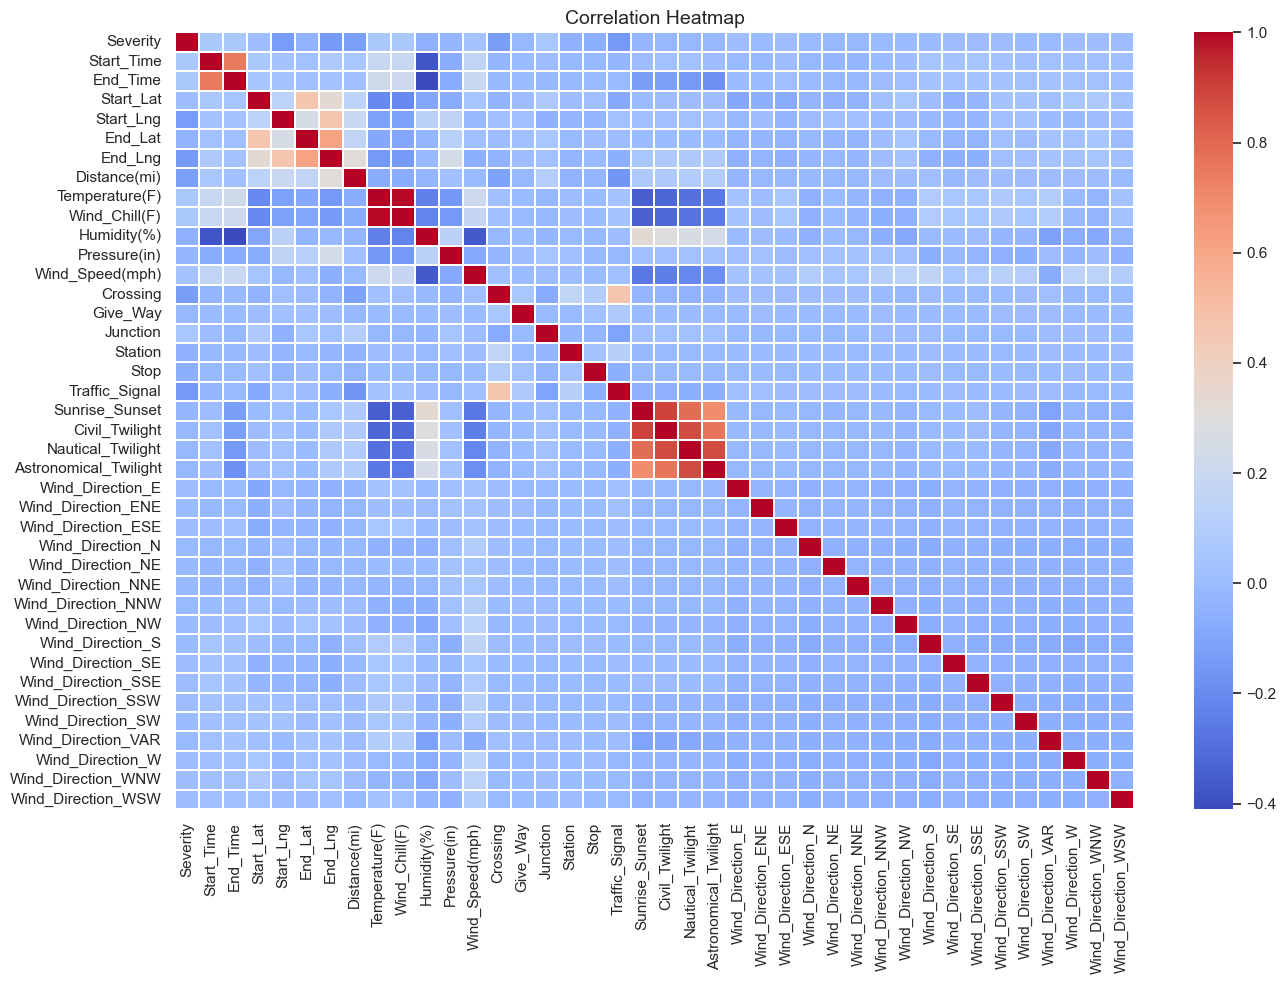

In [20]:

# Correlation Heatmap

df = df.loc[:, df.nunique() > 1]  # Corrected the typo

# Compute the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.2)
plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),...,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW
1,0,17.0,18.0,34.860432,-82.270523,36.181964,-88.040183,0.0,94.0,94.0,...,False,False,False,False,False,True,False,False,False,False
4,0,21.0,22.0,38.660870,-121.346870,36.181964,-88.040183,0.0,72.0,72.0,...,False,False,False,False,False,True,False,False,False,False
7,0,18.0,18.0,35.483261,-97.525497,36.181964,-88.040183,0.0,91.0,91.0,...,False,False,False,False,False,False,False,False,False,False
15,0,9.0,10.0,34.800980,-82.206261,36.181964,-88.040183,0.0,73.0,73.0,...,False,False,False,False,False,False,False,False,False,True
18,0,7.0,9.0,40.022449,-76.192902,36.181964,-88.040183,0.0,67.0,67.0,...,False,False,False,False,False,False,False,True,False,False


In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

# Separate features and target
X = df.drop(columns=['Severity'])
y = df['Severity']

# Split the data
print(" Splitting data into Train, Validation, and Test")
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

# Scaling
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Oversampling with SMOTE
print("Applying SMOTE for oversampling...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution after oversampling: \n{pd.Series(y_train_resampled).value_counts()}")


 Splitting data into Train, Validation, and Test
Scaling features...
Applying SMOTE for oversampling...
Class distribution after oversampling: 
Severity
0    63986
1    63986
Name: count, dtype: int64


In [34]:

#  Logistic Regression
print("\n Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_val_scaled)

print(" Logistic Regression validation Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_pred_lr))

# Test predictions
y_pred_test_lr = lr.predict(X_test_scaled)
print("\n Logistic Regression - Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_test_lr))





 Training Logistic Regression...
 Logistic Regression validation Results:
Accuracy: 0.6383298287774106
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.60      0.73     15997
           1       0.33      0.78      0.46      3977

    accuracy                           0.64     19974
   macro avg       0.62      0.69      0.59     19974
weighted avg       0.80      0.64      0.67     19974


 Logistic Regression - Test Results:
Accuracy: 0.6370954822172381
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.60      0.73     19997
           1       0.33      0.78      0.46      4971

    accuracy                           0.64     24968
   macro avg       0.62      0.69      0.59     24968
weighted avg       0.80      0.64      0.67     24968



In [36]:

# Random Forest Classifier
print("\n Training Random Forest Classifier...")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_val_scaled)

print(" Random Forest validation Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))

# Test predictions
y_pred_test_rf = rf.predict(X_test_scaled)
print("\nRandom forest - Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_test_rf))



 Training Random Forest Classifier...
 Random Forest validation Results:
Accuracy: 0.8255231801341745
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     15997
           1       0.57      0.53      0.55      3977

    accuracy                           0.83     19974
   macro avg       0.73      0.71      0.72     19974
weighted avg       0.82      0.83      0.82     19974


Random forest - Test Results:
Accuracy: 0.8276594040371675
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89     19997
           1       0.57      0.55      0.56      4971

    accuracy                           0.83     24968
   macro avg       0.73      0.72      0.73     24968
weighted avg       0.83      0.83      0.83     24968



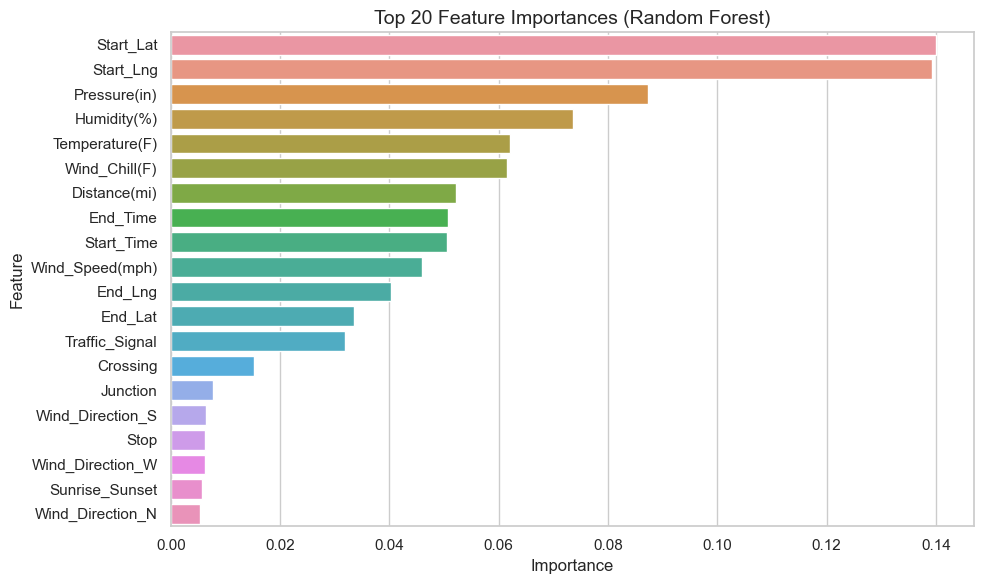

In [25]:
# Feature Importance (RF)

df['Severity'] = df['Severity'].apply(lambda x: 0 if x in [1, 2] else 1)  # Binary Conversion
X = df.drop(columns=['Severity'])
y = df['Severity']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=14)
plt.tight_layout()
plt.show()


In [37]:

from xgboost import XGBClassifier
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report


# Train XGBoost Model
print(" Training XGBoost...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = xgb_model.predict(X_val_scaled)
print("\n XGBoost Validation Results:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Test predictions
y_pred_test_xg = xgb_model.predict(X_test_scaled)
print("\n XGBOOST - Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_xg))
print("Classification Report:\n", classification_report(y_test, y_pred_test_xg))


 Training XGBoost...

 XGBoost Validation Results:
Accuracy: 0.8371382797636928
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     15997
           1       0.60      0.53      0.56      3977

    accuracy                           0.84     19974
   macro avg       0.75      0.72      0.73     19974
weighted avg       0.83      0.84      0.83     19974


 XGBOOST - Test Results:
Accuracy: 0.8376722204421659
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     19997
           1       0.60      0.54      0.57      4971

    accuracy                           0.84     24968
   macro avg       0.75      0.72      0.73     24968
weighted avg       0.83      0.84      0.83     24968



In [27]:
# SHAP Explainability with Actual Feature Names

import shap
import pandas as pd
import matplotlib.pyplot as plt

# Ensure you're using the same column names used before scaling
# Replace this with whatever feature DataFrame you used before scaling
X = df.drop(columns=['Severity'])
original_feature_names = X.columns  # or X_val.columns if you used that for scaling

# Sanity check (optional):
print(f" X_val_scaled shape: {X_val_scaled.shape}")
print(f" Number of original features: {len(original_feature_names)}")

# Create DataFrame with proper feature names
X_val_df = pd.DataFrame(X_val_scaled, columns=original_feature_names)

# Take a representative sample (optional: reduce runtime)
X_val_sample = X_val_df.sample(n=1000, random_state=42)

# SHAP Explainability
print(" Generating SHAP visualizations...")
explainer = shap.Explainer(xgb_model, X_val_sample)
shap_values = explainer(X_val_sample)


 X_val_scaled shape: (19974, 39)
 Number of original features: 39
 Generating SHAP visualizations...


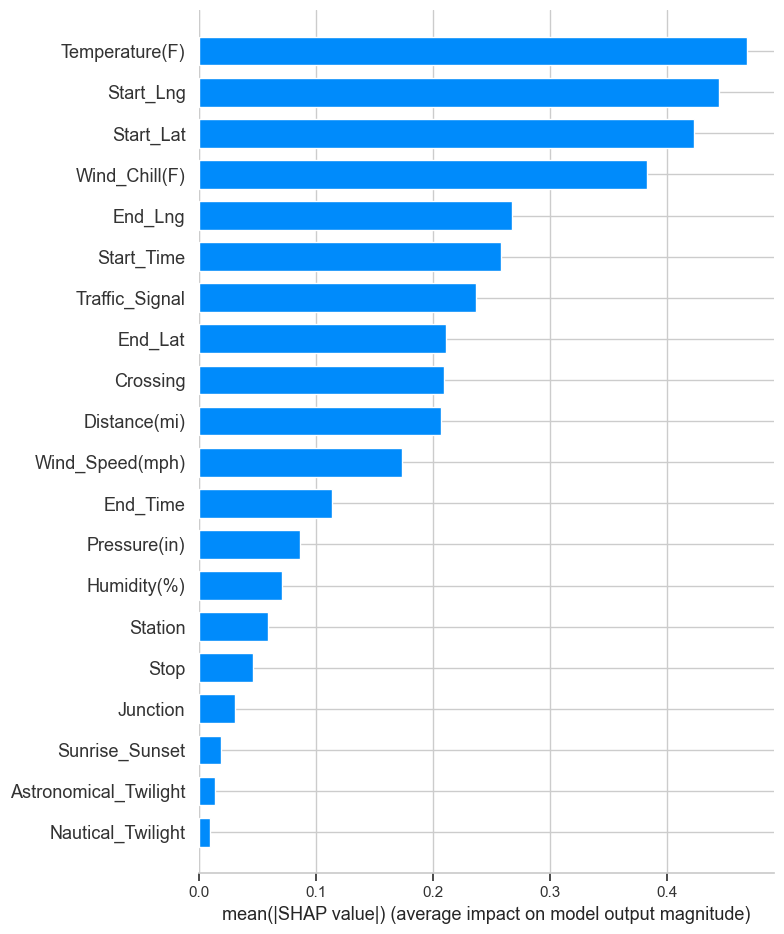

In [29]:
# Summary Plots
shap.summary_plot(shap_values, X_val_sample, plot_type="bar")  # Bar Plot of Importance


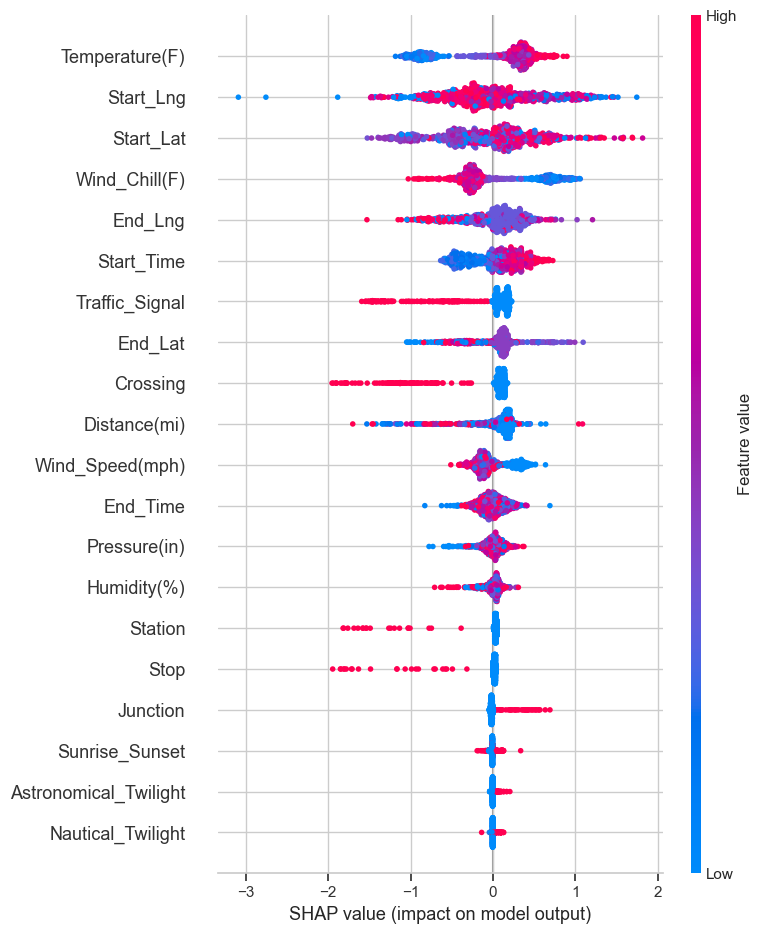

In [30]:
shap.summary_plot(shap_values, X_val_sample)  # Beeswarm Plot of Individual Effects

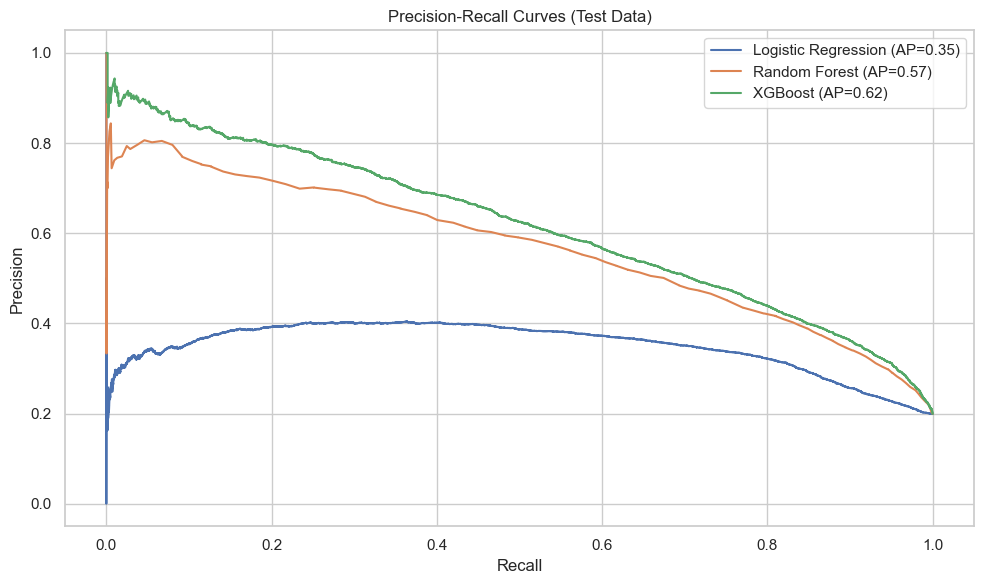

In [38]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import pandas as pd

# Predict probabilities for P-R curve
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_proba_xg = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Create PR Curves
plt.figure(figsize=(10, 6))

models_proba = {
    'Logistic Regression': y_proba_lr,
    'Random Forest': y_proba_rf,
    'XGBoost': y_proba_xg
}

pr_scores = {}
for name, y_score in models_proba.items():
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)
    pr_scores[name] = avg_precision

    plt.plot(recall, precision, label=f'{name} (AP={avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Test Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [41]:
# Calculate detailed metrics for both classes
comparison_data = []

for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    comparison_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score'],
        'Average Precision': pr_scores[name]
    })

# Display as DataFrame
comparison_df = pd.DataFrame(comparison_data).set_index('Model').sort_values(by='Average Precision', ascending=False)

print("\n Model Comparison (Per-Class Metrics on Test Data):")
display(comparison_df.round(2))




 Model Comparison (Per-Class Metrics on Test Data):


,Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Average Precision
Model,,,,,,,,
XGBoost,0.84,0.89,0.91,0.90,0.60,0.54,0.57,0.62
Random Forest,0.83,0.89,0.90,0.89,0.57,0.55,0.56,0.57
Logistic Regression,0.64,0.92,0.60,0.73,0.33,0.78,0.46,0.35


In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='average_precision',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print(" Starting hyperparameter tuning...")
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest Parameters Found:")
print(grid_search.best_params_)
print(f"Best Score (Avg Precision): {grid_search.best_score_:.4f}")


 Starting hyperparameter tuning...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters Found:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Score (Avg Precision): 0.9533


In [60]:
# Retrain XGBoost with best parameters
best_xgb = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("Training the optimized XGBoost model...")
best_xgb.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_best_xgb = best_xgb.predict(X_test_scaled)
y_proba_best_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
print("\nEvaluation on Test Set:")
print(classification_report(y_test, y_pred_best_xgb))

avg_precision = average_precision_score(y_test, y_proba_best_xgb)
print(f"Average Precision (PR AUC): {avg_precision:.4f}")


Training the optimized XGBoost model...

Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     19997
           1       0.64      0.52      0.58      4971

    accuracy                           0.85     24968
   macro avg       0.76      0.73      0.74     24968
weighted avg       0.84      0.85      0.84     24968

Average Precision (PR AUC): 0.6390


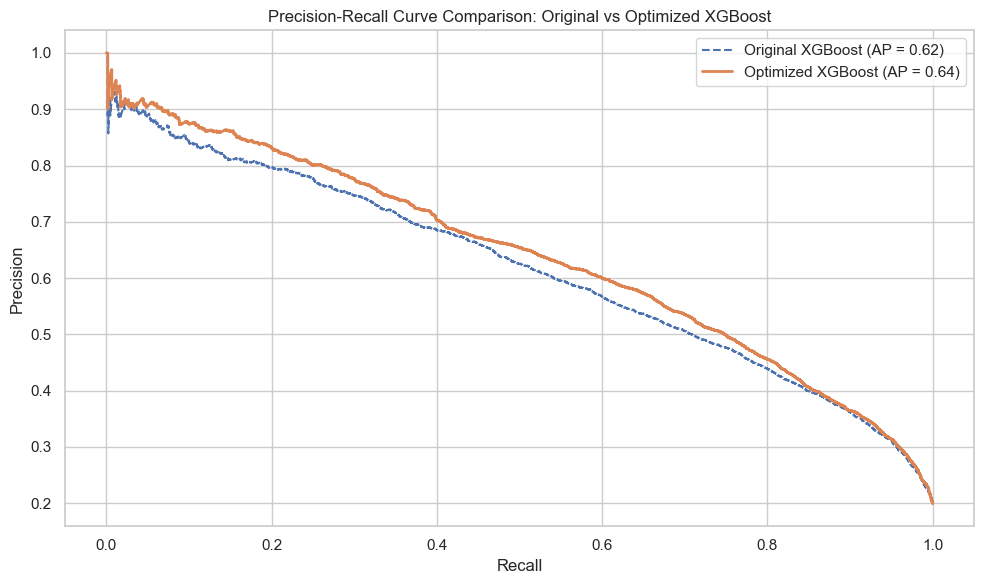

In [61]:
# Get probabilities from the original XGBoost model
y_proba_old_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision_old, recall_old, _ = precision_recall_curve(y_test, y_proba_old_xgb)
avg_precision_old = average_precision_score(y_test, y_proba_old_xgb)

# Optimized model (already calculated above)
precision_new, recall_new, _ = precision_recall_curve(y_test, y_proba_best_xgb)
avg_precision_new = average_precision_score(y_test, y_proba_best_xgb)

# Plot both curves
plt.figure(figsize=(10, 6))
plt.plot(recall_old, precision_old, label=f'Original XGBoost (AP = {avg_precision_old:.2f})', linestyle='--')
plt.plot(recall_new, precision_new, label=f'Optimized XGBoost (AP = {avg_precision_new:.2f})', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison: Original vs Optimized XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Final Model Comparison (Test Data Metrics):


,Accuracy,F1_0,F1_1,Average Precision
Model,,,,
XGBoost (Tuned),0.847,0.906,0.576,0.639
XGBoost (Base),0.838,0.900,0.568,0.616
Random Forest,0.828,0.893,0.558,0.566
Logistic Regression,0.637,0.726,0.462,0.350


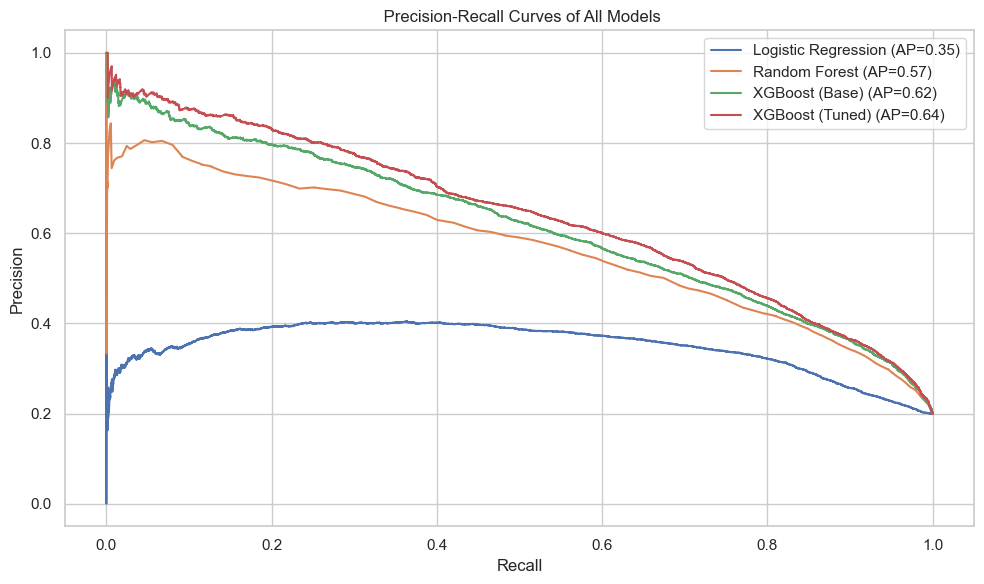

 Confusion Matrix - XGBoost (Tuned):


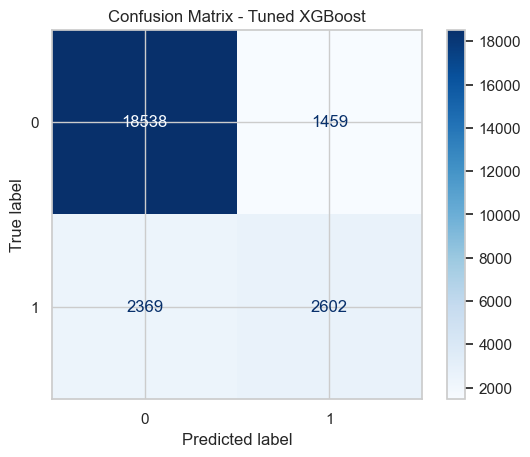

In [62]:
#  Final Model Evaluation and Comparison

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score, accuracy_score, f1_score
)
import matplotlib.pyplot as plt
import pandas as pd

# ---- Predict Probabilities for PR Curves ---- #
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_proba_old_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_proba_best_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# ----Get Predictions ---- #
y_pred_lr = y_pred_test_lr
y_pred_rf = y_pred_test_rf
y_pred_old_xgb = y_pred_test_xg
y_pred_best_xgb = best_xgb.predict(X_test_scaled)

# ---- Generate Final Comparison Table ---- #
def model_metrics(name, y_pred, y_proba):
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_0': report['0']['f1-score'],
        'F1_1': report['1']['f1-score'],
        'Average Precision': average_precision_score(y_test, y_proba)
    }

final_results = [
    model_metrics("Logistic Regression", y_pred_lr, y_proba_lr),
    model_metrics("Random Forest", y_pred_rf, y_proba_rf),
    model_metrics("XGBoost (Base)", y_pred_old_xgb, y_proba_old_xgb),
    model_metrics("XGBoost (Tuned)", y_pred_best_xgb, y_proba_best_xgb)
]

final_df = pd.DataFrame(final_results).set_index("Model").sort_values(by='Average Precision', ascending=False)
print(" Final Model Comparison (Test Data Metrics):")
display(final_df.round(3))

# ----Precision-Recall Curves ---- #
plt.figure(figsize=(10, 6))

for name, y_proba in zip(
    ["Logistic Regression", "Random Forest", "XGBoost (Base)", "XGBoost (Tuned)"],
    [y_proba_lr, y_proba_rf, y_proba_old_xgb, y_proba_best_xgb]
):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (AP={avg_prec:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(" Precision-Recall Curves of All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Confusion Matrix of Final Model ---- #
print(" Confusion Matrix - XGBoost (Tuned):")
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix - Tuned XGBoost")
plt.show()


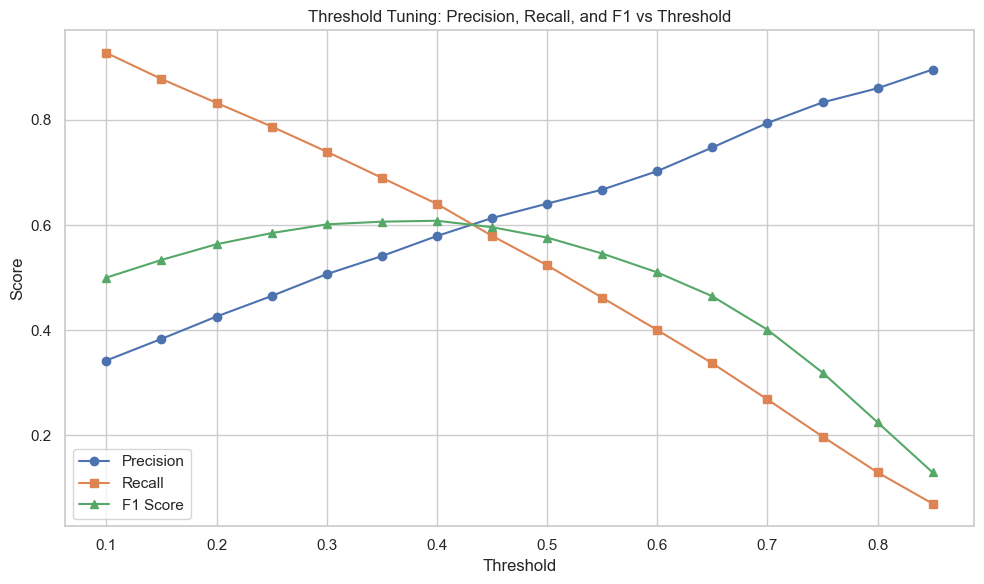

In [63]:
#threshold tuning
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
precision_list, recall_list, f1_list = [], [], []

# Get probabilities from optimized model
y_scores = best_xgb.predict_proba(X_test_scaled)[:, 1]

for t in thresholds:
    y_pred_thresh = (y_scores >= t).astype(int)
    precision_list.append(precision_score(y_test, y_pred_thresh))
    recall_list.append(recall_score(y_test, y_pred_thresh))
    f1_list.append(f1_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='s')
plt.plot(thresholds, f1_list, label='F1 Score', marker='^')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning: Precision, Recall, and F1 vs Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
final_threshold = 0.35
y_pred_final = (y_scores >= final_threshold).astype(int)
print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.92      0.85      0.88     19997
           1       0.54      0.69      0.61      4971

    accuracy                           0.82     24968
   macro avg       0.73      0.77      0.75     24968
weighted avg       0.84      0.82      0.83     24968



Classification Report (Threshold = 0.35 ):
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     19997
           1       0.54      0.69      0.61      4971

    accuracy                           0.82     24968
   macro avg       0.73      0.77      0.75     24968
weighted avg       0.84      0.82      0.83     24968



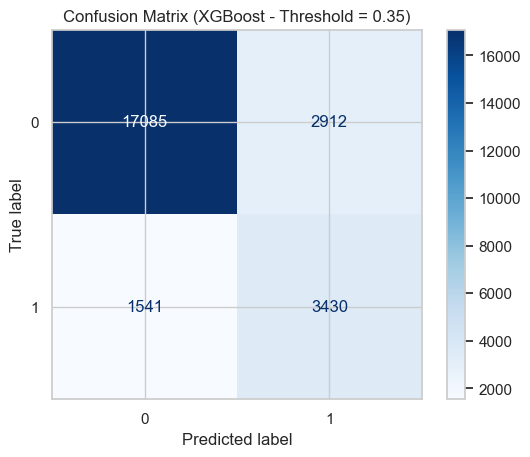

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set your selected threshold (adjust as needed)
final_threshold = 0.35

# Predict labels based on the threshold
y_pred_final = (y_scores >= final_threshold).astype(int)

# Print classification report
print("Classification Report (Threshold =", final_threshold, "):")
print(classification_report(y_test, y_pred_final, zero_division=0))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (XGBoost - Threshold = {final_threshold})")
plt.show()
